In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
import os
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed, MaxPooling1D, Flatten
from keras.regularizers import L1, L2
from keras.metrics import Accuracy, MSE, MAE, MAPE, RootMeanSquaredError

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_style("whitegrid")

In [4]:
df = pd.read_csv(r'..\data\HPG.csv')
df['date'] = pd.to_datetime(df['date'])
df.info()
df.describe().transpose()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2993 entries, 0 to 2992
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2993 non-null   datetime64[ns]
 1   high    2993 non-null   float64       
 2   low     2993 non-null   float64       
 3   open    2993 non-null   float64       
 4   close   2993 non-null   float64       
 5   adjust  2993 non-null   float64       
 6   volume  2993 non-null   int64         
 7   symbol  2993 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 187.2+ KB


date      0
high      0
low       0
open      0
close     0
adjust    0
volume    0
symbol    0
dtype: int64

In [5]:
data = df.drop(['date','symbol'],axis=1)
#close = df.filter(['close'])
#data.reset_index(drop=True, inplace=True)

In [6]:
data

,high,low,open,close,adjust,volume
0,61.00,60.00,60.00,61.0,1.97,653120
1,64.00,61.00,64.00,64.0,2.06,1203080
2,66.00,63.00,63.50,66.0,2.13,1771660
3,69.00,66.00,67.00,68.0,2.19,1535800
4,69.50,65.00,69.50,65.0,2.10,909010
...,...,...,...,...,...,...
2988,46.60,45.55,46.55,45.9,34.74,12180400
2989,46.70,45.60,45.90,45.8,34.66,13456300
2990,46.30,45.50,45.80,45.8,34.66,17659745
2991,46.30,45.70,46.30,45.7,34.59,11755870


In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data.values)

In [22]:
X = []
Y = []

for i in range (365, len(scaled_data)):
    X.append(scaled_data[i-365:i])
    Y.append(scaled_data[i])

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

x_train, x_test, y_train, y_test = np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

In [35]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],6,1))

In [66]:
model = Sequential()


# CNN layers
model.add(TimeDistributed(Conv1D(64, kernel_size=2, activation='relu', input_shape=(None, x_train.shape[1], x_train.shape[2],x_train.shape[3]))))
model.add(TimeDistributed(MaxPooling1D(1)))
model.add(TimeDistributed(Conv1D(64, kernel_size=2, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(1)))
model.add(TimeDistributed(Conv1D(64, kernel_size=2, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(1)))
model.add(TimeDistributed(Flatten()))
model.add(Dense(5, kernel_regularizer=L2(0.01)))


# LSTM layers
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='MSE', metrics=['MSE', 'MAE','RootMeanSquaredError','MAPE'])

history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=10,batch_size=40, verbose=1, shuffle =True)

Epoch 1/10
53/53 [==============================] - 201s 4s/step - loss: 0.1120 - MSE: 0.0427 - MAE: 0.1564 - root_mean_squared_error: 0.2067 - MAPE: 86481.8281 - val_loss: 0.0716 - val_MSE: 0.0275 - val_MAE: 0.1187 - val_root_mean_squared_error: 0.1659 - val_MAPE: 24111.8809
Epoch 2/10
53/53 [==============================] - 212s 4s/step - loss: 0.0585 - MSE: 0.0286 - MAE: 0.1279 - root_mean_squared_error: 0.1692 - MAPE: 47591.3906 - val_loss: 0.0452 - val_MSE: 0.0266 - val_MAE: 0.1221 - val_root_mean_squared_error: 0.1632 - val_MAPE: 14892.1221
Epoch 3/10
53/53 [==============================] - 220s 4s/step - loss: 0.0405 - MSE: 0.0280 - MAE: 0.1267 - root_mean_squared_error: 0.1674 - MAPE: 47156.4531 - val_loss: 0.0340 - val_MSE: 0.0262 - val_MAE: 0.1202 - val_root_mean_squared_error: 0.1620 - val_MAPE: 20337.1758
Epoch 4/10
53/53 [==============================] - 219s 4s/step - loss: 0.0330 - MSE: 0.0276 - MAE: 0.1253 - root_mean_squared_error: 0.1662 - MAPE: 40512.5195 - val_lo

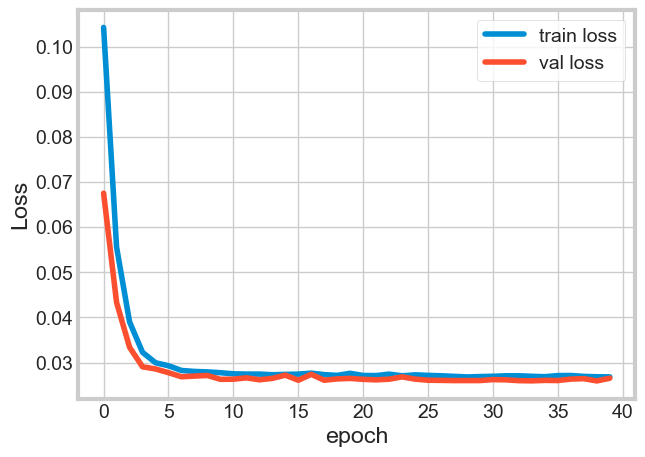

In [45]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

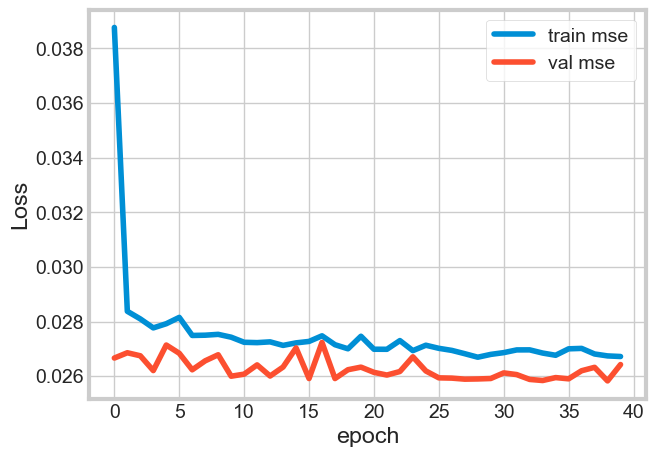

In [48]:
plt.plot(history.history['MSE'], label='train mse')
plt.plot(history.history['val_MSE'], label='val mse')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

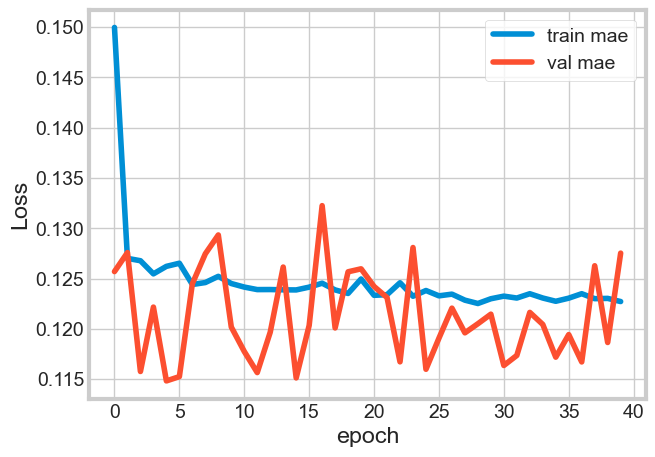

In [49]:
plt.plot(history.history['MAE'], label='train mae')
plt.plot(history.history['val_MAE'], label='val mae')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [50]:
# After the model has been constructed, we'll summarise it
from keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_79 (TimeDi  (None, 365, 5, 64)       192       
 stributed)                                                      
                                                                 
 time_distributed_80 (TimeDi  (None, 365, 5, 64)       0         
 stributed)                                                      
                                                                 
 time_distributed_81 (TimeDi  (None, 365, 4, 64)       8256      
 stributed)                                                      
                                                                 
 time_distributed_82 (TimeDi  (None, 365, 4, 64)       0         
 stributed)                                                      
                                                                 
 time_distributed_83 (TimeDi  (None, 365, 3, 64)     

In [51]:
model.evaluate(x_test, y_test)

17/17 [==============================] - 9s 526ms/step - loss: 0.0265 - MSE: 0.0264 - MAE: 0.1275 - root_mean_squared_error: 0.1626 - MAPE: 12939.2334


[0.026512160897254944,
 0.02642642892897129,
 0.12753193080425262,
 0.16256208717823029,
 12939.2333984375]

In [53]:
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error

# predict probabilities for test set
yhat_probs = model.predict(x_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(y_test, yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(y_test, yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(y_test, yhat_probs)
print('Max Error: %f' % var2)

ValueError: y_true and y_pred have different number of output (6!=1)

17/17 [==============================] - 9s 507ms/step


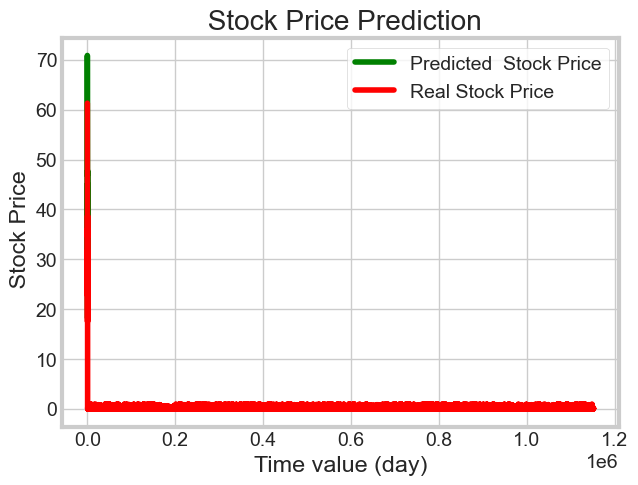

In [54]:
predicted  = model.predict(x_test)
test_label = x_test.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(x_train)
for j in range(len_t , len_t + len(x_test)):
    temp = data.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time value (day)')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [63]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],6,1))

In [64]:
predicted = model.predict(x_test)
predicted = scaler.inverse_transform(predicted)

ValueError: in user code:

    File "c:\Users\Chi\.conda\envs\stenv\lib\site-packages\keras\engine\training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Chi\.conda\envs\stenv\lib\site-packages\keras\engine\training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Chi\.conda\envs\stenv\lib\site-packages\keras\engine\training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Chi\.conda\envs\stenv\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
        return self(x, training=False)
    File "c:\Users\Chi\.conda\envs\stenv\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "sequential_15" (type Sequential).
    
    Cannot iterate over a shape with unknown rank.
    
    Call arguments received by layer "sequential_15" (type Sequential):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • training=False
      • mask=None


In [72]:
model.save(r'..\CNN-LSTM\model.h5')